# BASE 1719

Information:
* Periodo: 2017-2019
* Objetivo: predicción de pobreza

## 1. Importar datos y librerias

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt

In [3]:
path = r'..\..\input\vl\preprocessed_data\base19_21_anualizada_hogares.csv'
data_original = pd.read_csv( path )

In [4]:
data_original.shape

(48438, 155)

In [5]:
data_original[ 'gasto_monetario_deflactado_pc_m' ].mean()

571.5535823430168

### 2. Preprocesar datos

In [6]:
# # Imputación de valores del gasto del percentil 1% superior con valores del percentil 99

# percentil_superior = 0.01
# perc = data_original[ 'gasto_deflactado' ].quantile( 1 - percentil_superior )
# data.loc[ data_original [ 'gasto_deflactado' ] > perc, 'gasto_deflactado' ] = perc

In [7]:
next_vars = [ 'gasto_monetario_deflactado_pc_m', 'gasto_bruto_deflactado_pc_m', 
              'region', 'conglome',	'vivienda',	'hogar', 'gashog1d_pc_m', 
              'gashog2d_pc_m', 'n_personas_hogar', 
              'gasto_monetario_deflactado', 'gasto_bruto_deflactado',
              'gashog1d', 'gashog2d' ]
data      = data_original.drop(  next_vars , axis = 1 )

In [8]:
data = data.rename(columns = { 'ocu500_t_2': 'ocu500_t_2.0', 
                               'ocu500_t_1': 'ocu500_t_1.0',
                               'ocu500_t_4': 'ocu500_t_4.0',
                               'ocu500_t_3': 'ocu500_t_3.0',
                               'ocu500_t_0': 'ocu500_t_0.0' } )

### 3. Importar modelos entrenados y predecir

In [9]:
xgb_optimal_model_o = joblib.load( r'..\..\output\ejecucion_2\models\base_19_21\base_19_21_xgb_nrs.joblib' )

y_xgb_pred_class_o  = xgb_optimal_model_o.predict( data )
y_xgb_pred_prob_o   = xgb_optimal_model_o.predict_proba( data )[ :, 1 ]

In [10]:
y_xgb_pred_prob_o

array([0.13101797, 0.5720779 , 0.291695  , ..., 0.6205027 , 0.2804946 ,
       0.66791433], dtype=float32)

### 4. Identificar hogares vulnerables

In [11]:
data_completa = data_original.copy( deep = True )

data_completa[ 'class_pobreza' ] = y_xgb_pred_class_o
data_completa[ 'prob_pobreza' ]  = y_xgb_pred_prob_o

In [12]:
data_completa[ 'class_pobreza' ].value_counts( normalize = True )*100

0    65.875965
1    34.124035
Name: class_pobreza, dtype: float64

In [13]:
data_completa[ 'prob_pobreza' ]

0        0.131018
1        0.572078
2        0.291695
3        0.285086
4        0.438945
           ...   
48433    0.524471
48434    0.539603
48435    0.620503
48436    0.280495
48437    0.667914
Name: prob_pobreza, Length: 48438, dtype: float32

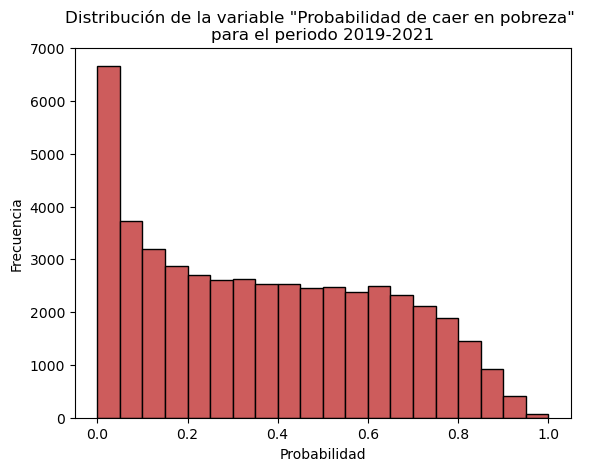

In [14]:
plt.hist( data_completa[ 'prob_pobreza' ], 
          bins = 20, 
          range = (0, 1), 
          edgecolor = 'black',
          color = 'indianred' )

plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "Probabilidad de caer en pobreza" \npara el periodo 2019-2021' )

plt.savefig( r'..\..\output\ejecucion_2\vl\plots\base_19_21\barplot_prob_1921.jpg', 
             format = 'jpg' )

plt.show()

Se considera distintas amplitudes de caliper: 
* 1: +-   2
* 2: +-   1
* 3: +- 0.5

Umbral de vulnerabilidade del periodo 2019-2021: 
* Valor real: 13.14
* Valor redondeado: 13

In [15]:
umbral_1921 = 0.09

limite_min_1 = umbral_1921 - 0.02
limite_max_1 = umbral_1921 + 0.02

limite_min_2 = umbral_1921 - 0.01
limite_max_2 = umbral_1921 + 0.01

limite_min_3 = umbral_1921 - 0.005
limite_max_3 = umbral_1921 + 0.005

hogares_vulnerables_1 = data_completa[ ( data_completa[ 'prob_pobreza' ] >= limite_min_1 ) & ( data_completa[ 'prob_pobreza' ] <= limite_max_1 ) ]
hogares_vulnerables_2 = data_completa[ ( data_completa[ 'prob_pobreza' ] >= limite_min_2 ) & ( data_completa[ 'prob_pobreza' ] <= limite_max_2 ) ]
hogares_vulnerables_3 = data_completa[ ( data_completa[ 'prob_pobreza' ] >= limite_min_3 ) & ( data_completa[ 'prob_pobreza' ] <= limite_max_3 ) ]

### 5. Calcular la línea de vulnerabilidad

In [16]:
linea_vul_1_gmd = hogares_vulnerables_1[ 'gasto_monetario_deflactado_pc_m' ].mean()
linea_vul_1_gbd = hogares_vulnerables_1[ 'gasto_bruto_deflactado_pc_m' ].mean()
linea_vul_1_gm  = hogares_vulnerables_1[ 'gashog1d_pc_m' ].mean()
linea_vul_1_gb  = hogares_vulnerables_1[ 'gashog2d_pc_m' ].mean()

In [17]:
linea_vul_2_gmd = hogares_vulnerables_2[ 'gasto_monetario_deflactado_pc_m' ].mean()
linea_vul_2_gbd = hogares_vulnerables_2[ 'gasto_bruto_deflactado_pc_m' ].mean()
linea_vul_2_gm  = hogares_vulnerables_2[ 'gashog1d_pc_m' ].mean()
linea_vul_2_gb  = hogares_vulnerables_2[ 'gashog2d_pc_m' ].mean()

In [18]:
linea_vul_3_gmd = hogares_vulnerables_3[ 'gasto_monetario_deflactado_pc_m' ].mean()
linea_vul_3_gbd = hogares_vulnerables_3[ 'gasto_bruto_deflactado_pc_m' ].mean()
linea_vul_3_gm  = hogares_vulnerables_3[ 'gashog1d_pc_m' ].mean()
linea_vul_3_gb  = hogares_vulnerables_3[ 'gashog2d_pc_m' ].mean()

In [19]:
table = np.zeros( ( 3, 4 ) )

table[ 0 ] = [ linea_vul_1_gmd, linea_vul_1_gbd, linea_vul_1_gm, linea_vul_1_gb ]
table[ 1 ] = [ linea_vul_2_gmd, linea_vul_2_gbd, linea_vul_2_gm, linea_vul_2_gb ]
table[ 2 ] = [ linea_vul_3_gmd, linea_vul_3_gbd, linea_vul_3_gm, linea_vul_3_gb ]

colnames = [ 'Gasto Monetario Deflactado', 'Gasto Bruto Deflactado', 'Gasto Monetario', 'Gasto Bruto' ]

rownames = [ 'Cáliper +- 2', 
             'Cáliper +- 1', 
             'Cáliper +- 0.5' ]

table_all = pd.DataFrame( table, columns = colnames )
table_all.index = rownames

table_all = table_all.round( 3 )
table_all

,Gasto Monetario Deflactado,Gasto Bruto Deflactado,Gasto Monetario,Gasto Bruto
Cáliper +- 2,707.506,966.310,807.695,1104.935
Cáliper +- 1,712.236,968.972,810.687,1104.657
Cáliper +- 0.5,732.290,1000.404,837.132,1143.193


In [20]:
table_all.to_excel( r'..\..\output\ejecucion_2\vl\results\base_19_21\vl_1921.xlsx' )